In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt


In [3]:
# Test dataset - Cox achieves C-index of 0.6403292470997135
from lifelines.datasets import load_rossi
rossi = load_rossi() 
X = rossi.copy()
T = X.pop('week').values
E = X.pop('arrest').values

In [9]:
from lifelines.utils.concordance import concordance_index
from gplearn_clean.gplearn.fitness import make_fitness

def c_metric(y_true, y_pred, w):
    try:
        return concordance_index(
            event_times = y_true, 
            predicted_scores = -y_pred, 
            event_observed = E[:len(y_pred)]
        )
    except ZeroDivisionError:
        return 0.5

c_fitness = make_fitness(function=c_metric, greater_is_better=True)

In [10]:
from gplearn_clean.gplearn.genetic import SymbolicRegressor 
est_gp = SymbolicRegressor(metric = c_fitness, population_size=500,
                           generations=20, stopping_criteria=0.75,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient='auto', random_state=0,
                           feature_names=X.columns.tolist())

est_gp.fit(X, T)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    28.72         0.491513       63         0.624137         0.624137     26.23s
   1    20.60         0.547153       11         0.636689         0.636689     22.84s
   2     8.44         0.561152        9         0.637124         0.637124     20.60s
   3     6.03         0.569606       35         0.638133         0.638133     18.92s
   4     4.74         0.572038        7         0.636924         0.636924     17.65s
   5     3.51         0.594628        5         0.636032         0.636032     16.81s
   6     5.64         0.599459       15         0.637171         0.637171     15.96s
   7    10.99         0.593065       29         0.637676         0.637676     15.43s
   8     5.26         0.590669       13         0.639672         0.639672  

SymbolicRegressor(feature_names=['fin', 'age', 'race', 'wexp', 'mar', 'paro',
                                 'prio'],
                  max_samples=0.9,
                  metric=<gplearn_clean.gplearn.fitness._Fitness object at 0x1551e0fd7760>,
                  p_crossover=0.7, p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient='auto',
                  population_size=500, random_state=0, stopping_criteria=0.75,
                  verbose=1)

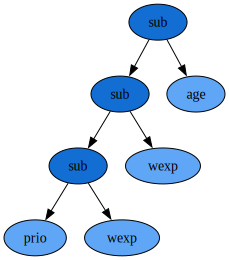

In [11]:
import graphviz
dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

In [13]:
partial_hazards = est_gp.predict(X)
partial_hazards[0:5]

array([-24, -10,  -8, -24, -18])

<Axes: xlabel='duration'>

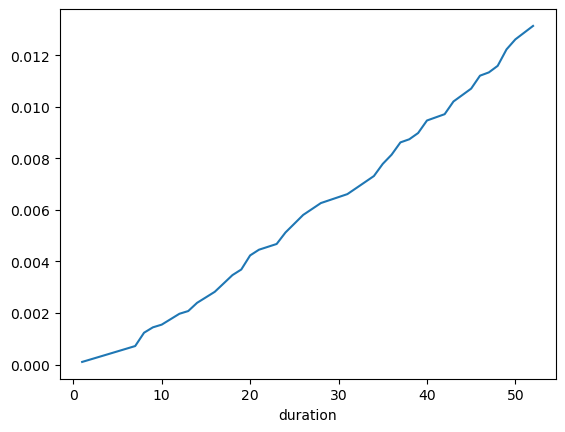

In [15]:
def compute_baseline_hazards(partial_hazards, T, E):
    # Here we are computing when expg when there are no events.
    #   Could be made faster, by only computing when there are events.
    expg = partial_hazards
    df = pd.DataFrame(dict(
        expg=expg,
        event=E,
        duration=T,
    ))
    return (df
            .groupby('duration')
            .agg('sum')
            .sort_index(ascending=False)
            .assign(expg=lambda x: x.expg.cumsum())
            .pipe(lambda x: x.event/x.expg)
            .fillna(0.)
            .iloc[::-1]
            .rename('baseline_hazards'))

def compute_baselime_cumulative_hazards(baseline_hazards):
    return baseline_hazards.cumsum()

cum_base_haz = compute_baselime_cumulative_hazards(compute_baseline_hazards(-partial_hazards, T, E))
cum_base_haz.plot()

<Axes: >

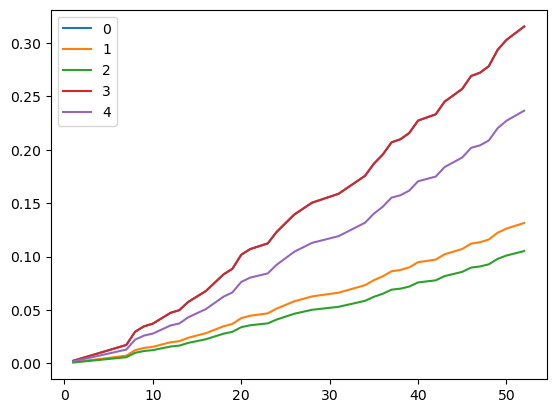

In [16]:
from lifelines.utils import interpolate_at_times

def predict_cumulative_hazard_lifelines(partial_hazards, baseline_cumulative_hazard, times) -> pd.DataFrame:
    n = len(partial_hazards)
    v = partial_hazards[0:5]

    times_to_evaluate_at = np.tile(times, (n, 1))
    c_0 = interpolate_at_times(baseline_cumulative_hazard, times_to_evaluate_at).T

    cumulative_hazard_ = pd.DataFrame(c_0 * v, columns=range(n), index=times)

    return cumulative_hazard_

predict_cumulative_hazard_lifelines(-partial_hazards[0:5], cum_base_haz, sorted(pd.Series(T).unique())).plot()

In [26]:
df = pd.DataFrame(dict(duration=T, event=E, lph=partial_hazards))
pll = (df
        .sort_values('duration', ascending=False)
        .assign(cum_ph=(lambda x: x['lph']
                        .pipe(np.exp)
                        .cumsum()
                        .groupby(x['duration'])
                        .transform('max')))
        .loc[lambda x: x['event'] == 1]
        .assign(pll=lambda x: x['lph'] - np.log(x['cum_ph']))
        ['pll'])
pll.mean()

-14.239460537135361

In [76]:
def _safe_inverse(x):
    _arr = isinstance(x,np.ndarray)
    if not _arr:
        x = np.array([x])
    mask = np.abs(x) < 0.001 
    result = np.zeros_like(x).astype(float)
    result[~mask] = 1/x[~mask]
    if not _arr:
        result = result[0]
    return result

In [78]:
def _safe_log(x):
    _arr = isinstance(x,np.ndarray)
    if not _arr:
        x = np.array([x])
    x = np.abs(x)
    mask = x < 0.001 
    x[mask] = 1
    result = np.log(x)
    if not _arr:
        result = result[0]
    return result

def _safe_div(num, denom):
    _arr = isinstance(num,np.ndarray)
    if not _arr:
        num = np.array([num])
        denom = np.array([denom])
    mask = np.abs(denom) < 0.001
    result = np.ones_like(num).astype(float)
    result[~mask] = num[~mask] / denom[~mask]
    print(result)
    if not _arr:
        result = result[0]
    return result

def _safe_inverse(x):
    _arr = isinstance(x,np.ndarray)
    if not _arr:
        x = np.array([x])
    mask = np.abs(x) < 0.001 
    result = np.zeros_like(x).astype(float)
    result[~mask] = 1/x[~mask]
    if not _arr:
        result = result[0]
    return result


def partial_log_likelihood_lifelines(partial_hazards: np.array, T: np.array, E: np.array):
    ordering = np.lexsort((E, T))
    T = T[ordering]
    E = E[ordering]
    partial_hazards = partial_hazards[ordering]
    n = len(E)

    log_lik = 0

    # Init risk and tie sums to zero
    x_death_sum = 0
    risk_phi, tie_phi = 0, 0

    # Init number of ties and weights
    weight_count = 0.0
    tied_death_counts = 0

    # Iterate backwards to utilize recursive relationship
    for i in range(n - 1, -1, -1):
        # Doing it like this to preserve shape
        ei = E[i]

        # Calculate phi values
        phi_i = partial_hazards[i]
        
        # Calculate sums of Risk set
        risk_phi = risk_phi + phi_i

        # Calculate sums of Ties, if this is an event
        if ei:
            try:
                x_death_sum = x_death_sum + _safe_log(partial_hazards[i])
            except RuntimeWarning:
                print(partial_hazards[i])
                
            tie_phi = tie_phi + phi_i

            # Keep track of count
            tied_death_counts += 1
            weight_count += 1

        # There are no more ties/members of the risk set and there are uncensored with the current time
        if not (i > 0 and T[i] == T[i - 1]) and tied_death_counts != 0:
            # There was at least one event and no more ties remain. Time to sum.
            # This code is near identical to the _batch algorithm below. In fact, see _batch for comments.
            weighted_average = weight_count / tied_death_counts

            if tied_death_counts > 1:
                increasing_proportion = np.arange(tied_death_counts) / tied_death_counts
                denom = _safe_inverse(risk_phi - increasing_proportion * tie_phi)
            else:
                denom = _safe_inverse(np.array([risk_phi]))

            log_lik = log_lik + x_death_sum + weighted_average * _safe_log(denom).sum()
            
            # reset tie values
            tied_death_counts = 0
            weight_count = 0.0
            x_death_sum = 0
            tie_phi = 0

    return log_lik/n

In [39]:
import warnings 
warnings.filterwarnings("error", category=RuntimeWarning)

In [134]:
#from pycox.evaluation.metrics import partial_log_likelihood_ph
from gplearn_clean.gplearn.fitness import make_fitness

def pll_metric(y_true, y_pred, w):
    value = partial_log_likelihood_lifelines(
        partial_hazards=y_pred,
        T = y_true, 
        E = E[:len(y_pred)]
    )
    if value > 0:
        value = -999
    return value 

lambda X: np.where(X > 0.001, np.log(np.maximum(X, 0.001)), 1)

def partial_log_likelihood_ph(y_pred, durations, events, mean=True):
    """Partial log-likelihood for PH models.
    
    Arguments:
        log_partial_hazards {np.array} -- Log partial hazards (e.g. x^T beta).
        durations {np.array} -- Durations.
        events {np.array} -- Events.
    
    Keyword Arguments:
        mean {bool} -- Return the mean. (default: {True})
    
    Returns:
        pd.Series or float -- partial log-likelihood or mean.
    """

    try:
        lph = _safe_log(y_pred)
        df = pd.DataFrame(dict(duration=durations, event=events, lph=lph))
        pll = (df
            .sort_values('duration', ascending=False)
            .assign(cum_ph=(lambda x: x['lph']
                                .pipe(np.exp)
                                .cumsum()
                                .groupby(x['duration'])
                                .transform('max')))
            .loc[lambda x: x['event'] == 1]
            .assign(pll=lambda x: x['lph'] - _safe_log(x['cum_ph']))
            ['pll'])
        if mean:
            return pll.mean()
    except RuntimeWarning:
        print(repr(y_pred))
    return pll

def pll_metric(y_true, y_pred, w):
    return partial_log_likelihood_ph(
        y_pred=y_pred,
        durations = y_true, 
        events = E[:len(y_pred)],
        mean=True
    )

pll_fitness = make_fitness(function=pll_metric, greater_is_better=True)

In [5]:
from gplearn_clean.gplearn.fitness import make_fitness
def deepsurv_loss_ez(y_pred, y_true, E):
    loss = 0
    n = len(y_true)
    for i in range(n): 
        if E[i] != 1: 
            continue 
        inner_sum = 0 

        for j in range(n): 
            if y_true[j] >= y_true[i]:
                inner_sum += np.exp(y_pred[j] - y_pred[i])

        loss += np.log(inner_sum)
    return loss/n

def deepsurv_loss_hard(y_pred, y_true, E, eps = 1e-7): 
    df = pd.DataFrame(dict(
        y_pred=y_pred,
        y_true=y_true,
        E=E
    )).sort_values('y_true', ascending=False)
    
    events = df.E 
    log_h = df.y_pred 
    gamma = log_h.max() 
    log_cumsum_h = np.log(np.exp(log_h.sub(gamma)).cumsum(0).add(eps)).add(gamma)
    return - log_h.sub(log_cumsum_h).mul(events).sum() / events.sum()

def ds_metric(y_true, y_pred, w):
    return deepsurv_loss_hard(
        y_pred=y_pred,
        y_true=y_true, 
        E=E[:len(y_pred)]
    )
ds_fitness = make_fitness(function=ds_metric, greater_is_better=False)

In [7]:
from gplearn_clean.gplearn.genetic import SymbolicRegressor 
est_gp = SymbolicRegressor(metric = ds_fitness, population_size=500,
                           generations=20, stopping_criteria=0,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient='auto', 
                           feature_names=X.columns.tolist())

est_gp.fit(X, T)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    29.53           230922       11          5.84902          5.84902     20.27s
   1     3.34          10.2923        3          5.85088          5.85088     17.15s
   2     1.67          9.47207        3          5.87672          5.87672     16.03s
   3     1.28           7.1869        3          5.87672          5.87672     15.16s
   4     1.39          10.5477        3          5.88038          5.88038     14.27s
   5     1.46          6.69918        7          5.87199          5.87199     13.40s
   6     1.43          10.8952        3          5.87672          5.87672     12.39s
   7     1.60          6.66917        3          5.89437          5.89437     11.40s
   8     1.30          12.1295        3          5.87826          5.87826  

SymbolicRegressor(feature_names=['fin', 'age', 'race', 'wexp', 'mar', 'paro',
                                 'prio'],
                  max_samples=0.9,
                  metric=<gplearn_clean.gplearn.fitness._Fitness object at 0x14ad3e704640>,
                  p_crossover=0.7, p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient='auto',
                  population_size=500, stopping_criteria=0, verbose=1)

In [89]:
y_pred = est_gp.predict(X)